In [ ]:
from GLM_Tools import modif_tools
from GLM_Tools.parsing_tools import *
import xml.etree.ElementTree as ET
import numpy as np
import re
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester"

glm_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Input_Data/"
glm_file_name = f"{substation_name}.glm"
glm_file = os.path.join(glm_file_dir,glm_file_name)

pkl_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/"
pkl_file_name = f"{substation_name}_Model.pkl"
pkl_file = os.path.join(pkl_file_dir,pkl_file_name)

print(f"Parsing {glm_file_name}...")

with open(glm_file, 'r') as file:
    glm_data = file.read()

# Get line impedance data
config_impedance_matrices = modif_tools.pull_line_impedances(root_dir, substation_name)

# Parse GLM file
first_obj = re.search(r"object (\S*) \{[^{}]*\}", glm_data, re.S)
header = glm_data[:first_obj.start()]

objects = []
node_objs = []
branch_objs = []
load_objs = []
shunt_objs = []
config_objs = []
helics_objs = []
misc_objs = []

Nodes = []
Branches = []
Loads = []
Generators = []
Shunts = []
Configs = []

for obj in re.finditer(r"object (\S*) \{[^{}]*\}", glm_data, re.S):
    objects.append(obj.group(0))
    obj_type = obj.group(1).strip('"')
    if obj_type in ["node","meter"]:
        node_string = obj.group(0)
        node_objs.append(node_string)
        Nodes.append(parse_node(node_string))
    elif obj_type in ["overhead_line", "underground_line", "transformer", "fuse", "switch", "sectionalizer", "recloser", "regulator"]:
        branch_string = obj.group(0)
        branch_objs.append(branch_string)
        Branches.append(parse_branch(obj_type,branch_string))
    elif obj_type in ["load"]:
        load_string = obj.group(0)
        load_objs.append(load_string)
        name_match = re.search(r"name\s+([^\s][^;]*);", load_string, re.S)
        if name_match:
            name = name_match.group(1)
        else:
            raise ValueError(f"Could not find name of load object: {load_string}")
        if "negLdGen" in name:
            Generators.append(parse_generator(load_string))
        else:
            Loads.append(parse_load(load_string))
    elif obj_type in ["capacitor"]:
        shunt_string = obj.group(0)
        shunt_objs.append(shunt_string)
        Shunts.append(parse_shunt(obj_type,shunt_string))
    elif obj_type in ["regulator_configuration", "transformer_configuration", "line_configuration"]:
        config_string = obj.group(0)
        config_objs.append(config_string)
        Configs.append(parse_config(obj_type,config_string, config_impedance_matrices))
    elif obj_type in ["helics_msg"]:
        helics_objs.append(obj.group(0))
    elif obj_type in ["voltdump", "currdump", "impedance_dump", "group_recorder", "recorder"]:
        misc_objs.append(obj.group(0))
    else:
        print(f"Unrecognized object type: {obj_type}")

miss_objs = len(objects) - (len(node_objs) + len(branch_objs) + len(load_objs) + len(shunt_objs) + len(config_objs) + len(helics_objs) + len(misc_objs))
if miss_objs > 0:
    print(f"Missing {miss_objs} objects.")
else:
    print(f"  Found all {len(objects)} objects.")
    print(f"  Found {len(node_objs)} node objects.")
    print(f"  Found {len(branch_objs)} branch objects.")
    print(f"  Found {len(load_objs)} load objects.")
    print(f"  Found {len(shunt_objs)} shunt objects.")
    print(f"  Found {len(config_objs)} config objects.")
    print(f"  Found {len(helics_objs)} helics_msg objects.")
    print(f"  Found {len(misc_objs)} misc objects.")

# Create a model from the components
Model = psm.PowerSystemModel(Nodes,Branches,Loads,Generators,Shunts,Configs)

Parsing Rochester.glm...
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: line_spacing
Missing 16 objects.


In [8]:
for config in Model.Configs:
    print(config.name)

<re.Match object; span=(34, 53), match='line_configuration0'>
<re.Match object; span=(34, 53), match='line_configuration1'>
<re.Match object; span=(34, 53), match='line_configuration2'>
<re.Match object; span=(34, 53), match='line_configuration3'>
<re.Match object; span=(34, 53), match='line_configuration4'>
<re.Match object; span=(34, 53), match='line_configuration5'>
<re.Match object; span=(34, 53), match='line_configuration6'>
<re.Match object; span=(34, 53), match='line_configuration7'>
<re.Match object; span=(34, 53), match='line_configuration8'>
<re.Match object; span=(34, 53), match='line_configuration9'>
<re.Match object; span=(34, 54), match='line_configuration10'>
<re.Match object; span=(34, 54), match='line_configuration11'>
<re.Match object; span=(34, 54), match='line_configuration12'>
<re.Match object; span=(34, 54), match='line_configuration13'>
<re.Match object; span=(34, 54), match='line_configuration14'>
<re.Match object; span=(34, 54), match='line_configuration15'>
<r

In [9]:
for branch in Model.Branches:
    if branch.type in ["overhead_line", "underground_line"]:
        config_name = branch.config
        print(config_name)

line_configuration1
line_configuration2
line_configuration2
line_configuration3
line_configuration2
line_configuration1
line_configuration2
line_configuration5
line_configuration1
line_configuration3
line_configuration0
line_configuration4
line_configuration3
line_configuration8
line_configuration2
line_configuration4
line_configuration9
line_configuration10
line_configuration11
line_configuration3
line_configuration0
line_configuration12
line_configuration7
line_configuration1
line_configuration0
line_configuration4
line_configuration0
line_configuration13
line_configuration14
line_configuration0
line_configuration3
line_configuration0
line_configuration4
line_configuration5
line_configuration0
line_configuration0
line_configuration8
line_configuration0
line_configuration3
line_configuration3
line_configuration3
line_configuration2
line_configuration4
line_configuration3
line_configuration0
line_configuration15
line_configuration4
line_configuration0
line_configuration0
line_configura

In [10]:
Model.Load_Dict = {obj.name: obj for obj in Model.Loads}
Model.Generator_Dict = {obj.name: obj for obj in Model.Generators}
Model.Shunt_Dict = {obj.name: obj for obj in Model.Shunts}
Model.Config_Dict = {obj.name: obj for obj in Model.Configs}

In [27]:
for obj in Model.Shunts:
    print(obj.name)

In [38]:
Configs = []

for obj in re.finditer(r"object (\S*) \{[^{}]*\}", glm_data, re.S):
    objects.append(obj.group(0))
    obj_type = obj.group(1).strip('"')
    if obj_type in ["regulator_configuration", "transformer_configuration", "line_configuration"]:
        config_string = obj.group(0)
        name_match = re.search(r"name\s+([^\s][^;]*);", config_string, re.S)
        if name_match:
            name = name_match.group(1)
            print(name)
            test = parse_config(obj_type,config_string, config_impedance_matrices)
            print(test.name)
        else:
            raise ValueError(f"Could not find name of config object: {config_string}")

line_configuration0
<re.Match object; span=(34, 53), match='line_configuration0'>
line_configuration1
<re.Match object; span=(34, 53), match='line_configuration1'>
line_configuration2
<re.Match object; span=(34, 53), match='line_configuration2'>
line_configuration3
<re.Match object; span=(34, 53), match='line_configuration3'>
line_configuration4
<re.Match object; span=(34, 53), match='line_configuration4'>
line_configuration5
<re.Match object; span=(34, 53), match='line_configuration5'>
line_configuration6
<re.Match object; span=(34, 53), match='line_configuration6'>
line_configuration7
<re.Match object; span=(34, 53), match='line_configuration7'>
line_configuration8
<re.Match object; span=(34, 53), match='line_configuration8'>
line_configuration9
<re.Match object; span=(34, 53), match='line_configuration9'>
line_configuration10
<re.Match object; span=(34, 54), match='line_configuration10'>
line_configuration11
<re.Match object; span=(34, 54), match='line_configuration11'>
line_configu

APPENDING LOCATION INFORMATION TO PKL

In [ ]:
import pandas as pd
import numpy as np
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester"
file_path = f"{root_dir}/Feeder_Data/{substation_name}/Output_Data/"

node_file = f"{root_dir}/Feeder_Data/{substation_name}/Coordinate_Data/Nodes.csv"
section_file = f"{root_dir}/Feeder_Data/{substation_name}/Coordinate_Data/Sections.csv"

# Parse nodes for coordinates
nodes = pd.read_csv(node_file)
node_keys = [*nodes]
node_IDs = nodes[node_keys[0]]
node_xs  = nodes[node_keys[4]]
node_ys  = nodes[node_keys[5]]

# Parse sections for topology
sections = pd.read_csv(section_file)
section_keys = [*sections]
section_IDs = sections[section_keys[0]]
section_froms = sections[section_keys[2]]
section_tos = sections[section_keys[4]]

# Open pkl file
pkl_file = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/{substation_name}_Model.pkl"
with open(pkl_file, 'rb') as file:
    pkl_model = pickle.load(file)

# find branch coordinates
for branch in pkl_model.Branches:
    from_node = pkl_model.Nodes[branch.from_node_ind]
    to_node = pkl_model.Nodes[branch.to_node_ind]
    from_ind = from_node.name.split("_")
    to_ind = to_node.name.split("_")
    for ii in range(len(from_ind)):
        if from_ind[ii].isnumeric():
            from_ind = np.copy(from_ind[ii:])
            break
    for ii in range(len(to_ind)):
        if to_ind[ii].isnumeric():
            to_ind = np.copy(to_ind[ii:])
            break
        
    if len(from_ind) == 1:
        from_ind = int(from_ind[0])
        x_coord = node_xs[from_ind]
        y_coord = node_ys[from_ind]
    else:
        intermediate_from_ind = int(from_ind[0])
        intermediate_to_ind = int(from_ind[1])
        intermediate_from_x_coord = node_xs[intermediate_from_ind]
        intermediate_from_y_coord = node_ys[intermediate_from_ind]
        intermediate_to_x_coord = node_xs[intermediate_to_ind]
        intermediate_to_y_coord = node_ys[intermediate_to_ind]
        x_coord = (intermediate_from_x_coord + intermediate_to_x_coord)/2
        y_coord = (intermediate_from_y_coord + intermediate_to_y_coord)/2

    if len(to_ind) == 1:
        to_ind = int(to_ind[0])
        x2_coord = node_xs[to_ind]
        y2_coord = node_ys[to_ind]
    else:
        intermediate_from_ind = int(to_ind[0])
        intermediate_to_ind = int(to_ind[1])
        intermediate_from_x2_coord = node_xs[intermediate_from_ind]
        intermediate_from_y2_coord = node_ys[intermediate_from_ind]
        intermediate_to_x2_coord = node_xs[intermediate_to_ind]
        intermediate_to_y2_coord = node_ys[intermediate_to_ind]
        x2_coord = (intermediate_from_x2_coord + intermediate_to_x2_coord)/2
        y2_coord = (intermediate_from_y2_coord + intermediate_to_y2_coord)/2
    
    branch.X_coord = np.copy(x_coord)
    branch.Y_coord = np.copy(y_coord)
    branch.X2_coord = np.copy(x2_coord)
    branch.Y2_coord = np.copy(y2_coord)

    # get node coordinates
    from_node = pkl_model.Nodes[branch.from_node_ind]
    to_node = pkl_model.Nodes[branch.to_node_ind]
    from_node.X_coord = branch.X2_coord
    from_node.Y_coord = branch.Y2_coord
    to_node.X_coord = branch.X_coord
    to_node.Y_coord = branch.Y_coord

# Save updated pkl file
with open(pkl_file, 'wb') as file:
    pickle.dump(pkl_model, file)

PLOTTING PKL

overhead_line_2_80
transformer550
fuse157
switch3
switch5
switch7
switch19
breaker0
regulator3
node_2388
node_3509
node_2473
node_3950
node_109
node_316
node_3435
node_4115
node_4115_4171


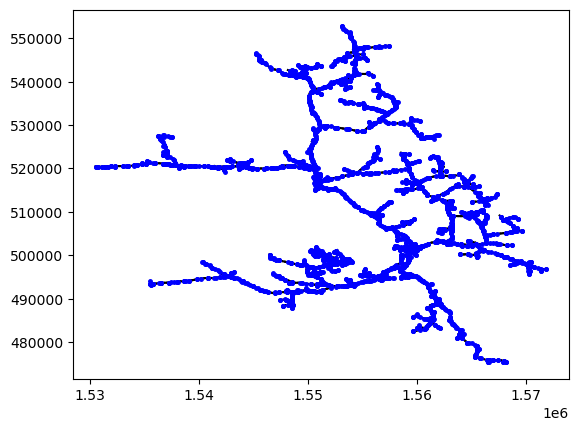

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Plotting PKL
# Open pkl file

root_dir = "C:/Users/egseg"
substation_name = "Rochester"
file_path = f"{root_dir}/Feeder_Data/{substation_name}/Output_Data/"

node_file = f"{root_dir}/Feeder_Data/{substation_name}/Coordinate_Data/Nodes.csv"
section_file = f"{root_dir}/Feeder_Data/{substation_name}/Coordinate_Data/Sections.csv"

# Parse nodes for coordinates
nodes = pd.read_csv(node_file)
node_keys = [*nodes]
node_IDs = nodes[node_keys[0]]
node_xs  = nodes[node_keys[4]]
node_ys  = nodes[node_keys[5]]

# Parse sections for topology
sections = pd.read_csv(section_file)
section_keys = [*sections]
section_IDs = sections[section_keys[0]]
section_froms = sections[section_keys[2]]
section_tos = sections[section_keys[4]]
pkl_file = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/{substation_name}_Model.pkl"
with open(pkl_file, 'rb') as file:
    pkl_model = pickle.load(file)

# Get indices of substation nodes 
substation_inds = np.where(node_xs == np.min(node_xs))[0]
islanded_ind = [1322, 3091] # indices of nodes that exist in a separate island (excluded from translation)
DNE_devices_section_inds = [1228, 3466, 3674, 3811, 2690, 3162, 4435, 4436] # indices of sections to be excluded from translation (explanation below)
DNE_nodes = [4430, 4431] # indices of nodes to be excluded from translation (explanation below)

for Branch in pkl_model.Branches:
    branch_from_ind = Branch.from_node.split("_")
    branch_to_ind = Branch.to_node.split("_")
    for ii in range(len(branch_from_ind)):
        if branch_from_ind[ii].isnumeric():
            branch_from_ind = np.copy(branch_from_ind[ii:])
            break
    for ii in range(len(branch_to_ind)):
        if branch_to_ind[ii].isnumeric():
            branch_to_ind = np.copy(branch_to_ind[ii:])
            break
    # Only include nodes in plot if they are not substation nodes
    if all(int(x) not in substation_inds for x in branch_from_ind) and all(int(x) not in substation_inds for x in branch_to_ind):
        plt.plot([Branch.X_coord,Branch.X2_coord],[Branch.Y_coord,Branch.Y2_coord],color='black')
    else:
        print(Branch.name)

for Node in pkl_model.Nodes:
    node_ind = Node.name.split("_")
    for ii in range(len(node_ind)):
        if node_ind[ii].isnumeric():
            node_inds = np.copy(node_ind[ii:])
            break
    if all(int(x) not in substation_inds for x in node_inds):
        plt.plot(Node.X_coord,Node.Y_coord,'b.',markersize=5)
    else:
        print(Node.name)

plt.show()

In [127]:
pkl_file = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/{substation_name}_Model.pkl"
with open(pkl_file, 'rb') as file:
    pkl_model = pickle.load(file)

for Branch in pkl_model.Branches:
    print(Branch.X_coord)

1558559.727
1562812.603
1554271.104
1552647.331
1567208.24
1559199.398
1568914.057
1556392.091
1559564.286
1554150.465
1565452.246
1536455.926
1535785.991
1546122.669
1564015.062
1542246.03
1563904.034
1554389.89
1550422.897
1554029.658
1561097.403
1559394.88
1556886.017
1551143.538
1557310.638
1532688.183
1561876.86
1559536.397
1551825.575
1553438.873
1542405.014
1558890.58
1544909.744
1553231.411
1559908.888
1558095.342
1544232.712
1553194.538
1550560.521
1552463.729
1549851.492
1560758.283
1538705.009
1554010.704
1561197.685
1543447.91
1554766.89
1562728.081
1550498.967
1550704.897
1559143.413
1550227.427
1544358.584
1548056.686
1558560.17
1565319.75
1552887.892
1559014.553
1558505.925
1560242.5
1554272.889
1555246.89
1566289.676
1539585.792
1549702.186
1562283.972
1564039.605
1553058.558
1550739.897
1550587.417
1557281.754
1558995.396
1551254.061
1541703.577
1562918.434
1561338.344
1550687.896
1563905.268
1554129.89
1542897.893
1551349.378
1565360.583
1564889.498
1564642.483
153578

In [18]:
substation_inds

array([ 109,  316, 2388, 2473, 3435, 3509, 3950, 4115], dtype=int64)

In [21]:
ind = 0
for branch in pkl_model.Branches:
    if branch.name == 'overhead_line_2_80':
        print(ind)
    ind += 1

pkl_model.Branches[2408]
pkl_model.Branches[241]

2408


Branch(type=overhead_line,name=overhead_line241,from_node=node_3437,to_node=node_3049,phases=C)

SUBFEEDER TESTING

In [36]:
pkl_model.Branches

[Branch(type=overhead_line,name=overhead_line0,from_node=node_3011,to_node=node_1036,phases=ABC),
 Branch(type=overhead_line,name=overhead_line1,from_node=node_3972,to_node=node_65,phases=C),
 Branch(type=overhead_line,name=overhead_line2,from_node=node_2517,to_node=node_4116,phases=C),
 Branch(type=overhead_line,name=overhead_line3,from_node=node_4313,to_node=node_3200,phases=A),
 Branch(type=overhead_line,name=overhead_line4,from_node=node_1251,to_node=node_2736,phases=C),
 Branch(type=overhead_line,name=overhead_line5,from_node=node_2268,to_node=node_1490,phases=ABC),
 Branch(type=overhead_line,name=overhead_line6,from_node=node_3851,to_node=node_4274,phases=C),
 Branch(type=overhead_line,name=overhead_line7,from_node=node_1995,to_node=node_3535,phases=ABC),
 Branch(type=overhead_line,name=overhead_line8,from_node=node_1986,to_node=node_1736,phases=ABC),
 Branch(type=overhead_line,name=overhead_line9,from_node=node_711,to_node=node_3050,phases=A),
 Branch(type=overhead_line,name=ove

In [39]:
import os
from GLM_Tools import modif_tools
from GLM_Tools.parsing_tools import *
import xml.etree.ElementTree as ET
import numpy as np
import re
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester_1"
n_nodes = 2
subfeeder_name = f"N_{n_nodes}"
start_node_name = "node_2388"
branches_to_remove = []

new_substation_name = f"{substation_name}_{subfeeder_name}"

pkl_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/"
pkl_file_name = f"{substation_name}_Model.pkl"
pkl_file = os.path.join(pkl_file_dir,pkl_file_name)

with open(pkl_file, 'rb') as file:
    pkl_model = pickle.load(file)

start_node = pkl_model.Node_Dict[start_node_name]

# depth first search
New_Nodes = []
New_Branches = []
has_swing = False
visited_nodes = set()
visited_branches = set()
nodes_to_visit = [start_node.index]
while nodes_to_visit and len(visited_nodes) <= n_nodes:
    node_ind = nodes_to_visit.pop()
    if node_ind not in visited_nodes:
        visited_nodes.add(node_ind)
        node = pkl_model.Nodes[node_ind]
        New_Nodes.append(node)
        if node.node_type == "SWING":
            has_swing = True
        for branch_ind in node.outgoing_branches:
            branch = pkl_model.Branches[branch_ind]
            if branch.name not in branches_to_remove and len(visited_nodes) < n_nodes:
                if branch.from_node_ind != node_ind:
                    ValueError(f"Outgoing branch ({branch_ind}) from_node_ind ({branch.from_node_ind}) doesn't match node_ind {node_ind}")
                if branch.to_node_ind not in visited_nodes:
                    nodes_to_visit.append(branch.to_node_ind)
                if branch.index not in visited_branches:
                    New_Branches.append(branch)
                    visited_branches.add(branch.index)

        for branch_ind in node.incoming_branches:
            branch = pkl_model.Branches[branch_ind]
            if branch.name not in branches_to_remove and len(visited_nodes) < n_nodes:
                if branch.to_node_ind != node_ind:
                    ValueError(f"Incoming branch ({branch_ind}) to_node_ind ({branch.to_node_ind}) doesn't match node_ind {node_ind}")
                if branch.from_node_ind not in visited_nodes:
                    nodes_to_visit.append(branch.from_node_ind)
                if branch.index not in visited_branches:
                    New_Branches.append(branch)
                    visited_branches.add(branch.index)
        
        for child_ind in node.child_nodes:
            nodes_to_visit.append(child_ind)

# add relevant loads to the new model
New_Loads = []
for Load in pkl_model.Loads:
    if Load.parent_node_ind in visited_nodes:
        New_Loads.append(Load)

# add relevant loads to the new model
New_Generators = []
for Generator in pkl_model.Generators:
    if Generator.parent_node_ind in visited_nodes:
        New_Generators.append(Generator)

# add relevant shunts to the new model
New_Shunts = []
for Shunt in pkl_model.Shunts:
    if Shunt.parent_node_ind in visited_nodes:
        New_Shunts.append(Shunt)

# add relevant configs to the new model
New_Configs = []
configs_visited = set()
for Branch in New_Branches:
    if hasattr(Branch, 'config'):
        config_name = Branch.config
        if config_name not in pkl_model.Config_Dict:
            raise ValueError(f"Could not find line config object: {config_name}")
        branch_config = pkl_model.Config_Dict[config_name] 
        if branch_config.index not in configs_visited:
            New_Configs.append(branch_config)
            configs_visited.add(branch_config.index)

# make sure there is a swing node in the model
if not has_swing:
    # change first node (start_node) to swing node
    New_Nodes[0].node_type = "SWING"
    Vbase = New_Nodes[0].Vbase
    voltage_A = Vbase
    voltage_B = Vbase*np.exp(1j*(-2*np.pi/3))
    voltage_C = Vbase*np.exp(1j*(2*np.pi/3))
    voltage_A_str = "{:+}{:+}j".format(voltage_A.real, voltage_A.imag)
    voltage_B_str = "{:+}{:+}j".format(voltage_B.real, voltage_B.imag)
    voltage_C_str = "{:+}{:+}j".format(voltage_C.real, voltage_C.imag)
    old_glm_string = New_Nodes[0].glm_string 
    add_swing_string = f"bustype SWING; voltage_A {voltage_A_str}; voltage_B {voltage_B_str}; voltage_C {voltage_C_str}; "
    new_glm_string = old_glm_string[:-1] + add_swing_string + old_glm_string[-1]
    New_Nodes[0].glm_string = new_glm_string

# Create a new model
New_Model = psm.PowerSystemModel(New_Nodes,New_Branches,New_Loads,New_Generators,New_Shunts,New_Configs)

New_Model.compute_impedances()

# update header, helics object, and recorder objects
New_Model.glm_header = pkl_model.glm_header
New_Model.glm_helics_obj = pkl_model.glm_helics_obj.replace(substation_name,new_substation_name)
new_glm_misc_objs = []
for misc_obj in pkl_model.glm_misc_objs:
    new_misc_obj = misc_obj.replace(substation_name,new_substation_name)
    # update substation recorder parent
    if "substation_power.csv" in new_misc_obj:
        parent_match = re.search(r"parent\s+([^\s][^;]*);", new_misc_obj, re.S)
        if parent_match:
            parent = parent_match.group(1)
        else:
            raise ValueError(f"Could not find parent of substation recorder object: {new_misc_obj}")
        new_parent = New_Branches[0].name
        new_misc_obj = new_misc_obj.replace(parent,new_parent)
    new_glm_misc_objs.append(new_misc_obj)
New_Model.glm_misc_objs = new_glm_misc_objs


# Save the new power system model to a .pkl
new_pkl_file_dir = f"Feeder_Data/{new_substation_name}/Python_Model/"
new_pkl_file_name = f"{new_substation_name}_Model.pkl"
new_pkl_file = os.path.join(new_pkl_file_dir,new_pkl_file_name)
if not os.path.exists(new_pkl_file_dir):
    os.makedirs(new_pkl_file_dir)
with open(new_pkl_file, 'wb') as file:
    pickle.dump(New_Model, file)

# write a glm file for the new model
new_glm_file_dir = f"Feeder_Data/{new_substation_name}/Input_Data/"
new_glm_file_name = f"{new_substation_name}_Helics.glm"
new_glm_file = os.path.join(new_glm_file_dir,new_glm_file_name)

if not os.path.exists(new_glm_file_dir):
    os.makedirs(new_glm_file_dir)
glm_parser.create_glm_from_pkl(new_pkl_file,new_glm_file)

print(f"Created a new subfeeder ({subfeeder_name}) for {substation_name}. Python model saved to {new_pkl_file}. GridLAB-D model saved to {new_glm_file}")

# copy over the files we need to run the simulation
shutil.copy(f"Feeder_Data/{substation_name}/meter_number_data.csv",f"Feeder_Data/{new_substation_name}/")
shutil.copy(f"Feeder_Data/{substation_name}/gen_meter_number_data.csv",f"Feeder_Data/{new_substation_name}/")
if not os.path.exists(f"Feeder_Data/{new_substation_name}/AMI_Data/"):
    os.makedirs(f"Feeder_Data/{new_substation_name}/AMI_Data/")
shutil.copy(f"Feeder_Data/{substation_name}/AMI_Data/{substation_name}_True_Load_AMI_Data.csv",f"Feeder_Data/{new_substation_name}/AMI_Data/{new_substation_name}_True_Load_AMI_Data.csv")
shutil.copy(f"Feeder_Data/{substation_name}/AMI_Data/{substation_name}_True_Gen_AMI_Data.csv",f"Feeder_Data/{new_substation_name}/AMI_Data/{new_substation_name}_True_Gen_AMI_Data.csv")
if not os.path.exists(f"Feeder_Data/{new_substation_name}/Coordinate_Data/"):
    os.makedirs(f"Feeder_Data/{new_substation_name}/Coordinate_Data/")
shutil.copy(f"Feeder_Data/{substation_name}/Coordinate_Data/{substation_name}_Branch_Coords.xls",f"Feeder_Data/{new_substation_name}/Coordinate_Data/{new_substation_name}_Branch_Coords.xls")


NameError: name 'glm_parser' is not defined

ADDING GENERATORS TO PKL

In [11]:
import os
from GLM_Tools import modif_tools
from GLM_Tools.parsing_tools import *
import xml.etree.ElementTree as ET
import numpy as np
import re
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester_1"
impedance_dump_name = "impedancedump_1"

glm_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Input_Data/"
glm_file_name = f"{substation_name}.glm"
glm_file = os.path.join(glm_file_dir,glm_file_name)

pkl_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/"
pkl_file_name = f"{substation_name}_Model.pkl"
pkl_file = os.path.join(pkl_file_dir,pkl_file_name)

print(f"Parsing {glm_file_name}...")

with open(glm_file, 'r') as file:
    glm_data = file.read()

# Get line impedance data
config_impedance_matrices = modif_tools.pull_line_impedances(root_dir, substation_name, impedance_dump_name)

# Parse GLM file
first_obj = re.search(r"object (\S*) \{[^{}]*\}", glm_data, re.S)
header = glm_data[:first_obj.start()]

objects = []
node_objs = []
branch_objs = []
load_objs = []
shunt_objs = []
config_objs = []
helics_objs = []
misc_objs = []

Nodes = []
Branches = []
Loads = []
Generators = []
Shunts = []
Configs = []

load_params = []

for obj in re.finditer(r"object (\S*) \{[^{}]*\}", glm_data, re.S):
    objects.append(obj.group(0))
    obj_type = obj.group(1).strip('"')
    if obj_type in ["load"]:
        load_string = obj.group(0)
        #print(load_string)
        load_objs.append(load_string)
        name_match = re.search(r"name\s+([^\s][^;]*);", load_string, re.S)
        if name_match:
            name = name_match.group(1)
        else:
            raise ValueError(f"Could not find name of load object: {load_string}")
        if "PV" in name:
            Generators.append(parse_generator(load_string))
        else:
            name_match = re.search(r"name\s+([^\s][^;]*);", load_string, re.S)
            if name_match:
                name = name_match.group(1)
            else:
                raise ValueError(f"Could not find name of load object: {load_string}")
            
            parent_match = re.search(r"parent\s+([^\s][^;]*);", load_string, re.S)
            if parent_match:
                parent = parent_match.group(1)
            else:
                raise ValueError(f"Could not find parent of load object: {load_string}")
            
            phases_match = re.search(r"phases\s+([ABCDN]*);", load_string, re.S)
            if phases_match:
                phases = phases_match.group(1)
            else:
                raise ValueError(f"Could not find phases of load object: {load_string}")
            
            nom_volt_match = re.search(r"nominal_voltage\s+(\d+(\.\d+)?);", load_string, re.S)
            if nom_volt_match:
                nom_volt = float(nom_volt_match.group(1))
            else:
                raise ValueError(f"Could not find phases of load object: {load_string}")
            
            for ph in ["A","B","C"]:
                constant_power_match = re.search(fr"constant_power_{ph}\s+([+-]?\d+(?:\.\d+)?[+-]\d+(?:\.\d+)?j);", load_string, re.S)
                print(constant_power_match)
                if constant_power_match:
                    constant_power = complex(constant_power_match.group(1))
                else:
                    constant_power = complex(0,0)
                load_params.append(constant_power)
                #print("constant power = " + str(constant_power))

        print(psm.Load(name,parent,phases,nom_volt,load_params,load_string))

Parsing Rochester_1.glm...
None
None
<re.Match object; span=(79, 109), match='constant_power_C 5560+969.97j;'>
Load(name=spot_load_3004,parent=spot_load_meter_3004,phases=C,base_voltage=240.0)
<re.Match object; span=(77, 108), match='constant_power_A 3680+604.985j;'>
None
None
Load(name=spot_load_938,parent=spot_load_meter_938,phases=A,base_voltage=240.0)
<re.Match object; span=(77, 119), match='constant_power_A 6440+1444.9850000000001j;'>
None
None
Load(name=spot_load_903,parent=spot_load_meter_903,phases=A,base_voltage=240.0)
None
None
None
Load(name=spot_load_3148,parent=spot_load_meter_3148,phases=A,base_voltage=240.0)
None
None
None
Load(name=spot_load_83,parent=spot_load_meter_83,phases=C,base_voltage=240.0)
None
None
<re.Match object; span=(79, 112), match='constant_power_C 49368+26137.97j;'>
Load(name=spot_load_3874,parent=spot_load_meter_3874,phases=C,base_voltage=240.0)
<re.Match object; span=(79, 109), match='constant_power_A 4000+569.97j;'>
None
None
Load(name=spot_load_194

In [1]:
import os
from GLM_Tools import modif_tools
from GLM_Tools.parsing_tools import *
import xml.etree.ElementTree as ET
import numpy as np
import re
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester_1"
impedance_dump_name = "impedancedump_1"

glm_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Input_Data/"
glm_file_name = f"{substation_name}.glm"
glm_file = os.path.join(glm_file_dir,glm_file_name)

pkl_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/"
pkl_file_name = f"{substation_name}_Model.pkl"
pkl_file = os.path.join(pkl_file_dir,pkl_file_name)

print(f"Parsing {glm_file_name}...")

with open(glm_file, 'r') as file:
    glm_data = file.read()

# Get line impedance data
config_impedance_matrices = modif_tools.pull_line_impedances(root_dir, substation_name, impedance_dump_name)

# Parse GLM file
first_obj = re.search(r"object (\S*) \{[^{}]*\}", glm_data, re.S)
header = glm_data[:first_obj.start()]

objects = []
node_objs = []
branch_objs = []
load_objs = []
shunt_objs = []
config_objs = []
helics_objs = []
misc_objs = []

Nodes = []
Branches = []
Loads = []
Generators = []
Shunts = []
Configs = []

for obj in re.finditer(r"object (\S*) \{[^{}]*\}", glm_data, re.S):
    objects.append(obj.group(0))
    obj_type = obj.group(1).strip('"')
    if obj_type in ["node","meter"]:
        node_string = obj.group(0)
        node_objs.append(node_string)
        Nodes.append(parse_node(node_string))
    elif obj_type in ["overhead_line", "underground_line", "transformer", "fuse", "switch", "sectionalizer", "recloser", "regulator"]:
        branch_string = obj.group(0)
        branch_objs.append(branch_string)
        Branches.append(parse_branch(obj_type,branch_string))
    elif obj_type in ["load"]:
        load_string = obj.group(0)
        load_objs.append(load_string)
        name_match = re.search(r"name\s+([^\s][^;]*);", load_string, re.S)
        if name_match:
            name = name_match.group(1)
        else:
            raise ValueError(f"Could not find name of load object: {load_string}")
        if "negLdGen" in name or "PV" in name:
            Generators.append(parse_generator(load_string))
        else:
            Loads.append(parse_load(load_string))
    elif obj_type in ["capacitor"]:
        shunt_string = obj.group(0)
        shunt_objs.append(shunt_string)
        Shunts.append(parse_shunt(obj_type,shunt_string))
    elif obj_type in ["regulator_configuration", "transformer_configuration", "line_configuration"]:
        config_string = obj.group(0)
        config_objs.append(config_string)
        Configs.append(parse_config(obj_type,config_string, config_impedance_matrices))
    elif obj_type in ["helics_msg"]:
        helics_objs.append(obj.group(0))
    elif obj_type in ["voltdump", "currdump", "impedance_dump", "group_recorder", "recorder"]:
        misc_objs.append(obj.group(0))
    else:
        print(f"Unrecognized object type: {obj_type}")

miss_objs = len(objects) - (len(node_objs) + len(branch_objs) + len(load_objs) + len(shunt_objs) + len(config_objs) + len(helics_objs) + len(misc_objs))
if miss_objs > 0:
    print(f"Missing {miss_objs} objects.")
else:
    print(f"  Found all {len(objects)} objects.")
    print(f"  Found {len(node_objs)} node objects.")
    print(f"  Found {len(branch_objs)} branch objects.")
    print(f"  Found {len(load_objs)} load objects.")
    print(f"  Found {len(shunt_objs)} shunt objects.")
    print(f"  Found {len(config_objs)} config objects.")
    print(f"  Found {len(helics_objs)} helics_msg objects.")
    print(f"  Found {len(misc_objs)} misc objects.")

# Create a model from the components
Model = psm.PowerSystemModel(Nodes,Branches,Loads,Generators,Shunts,Configs)

Model.compute_impedances()

Model.glm_header = header
if len(helics_objs) > 0:
    Model.glm_helics_obj = helics_objs[0]
Model.glm_misc_objs = misc_objs

# Save the power system model
if not os.path.exists(pkl_file_dir):
    os.makedirs(pkl_file_dir)
with open(pkl_file, 'wb') as file:
    pickle.dump(Model, file)

print(f"Done parsing {glm_file_name}. Python model saved to {pkl_file}.")



Parsing Rochester_1.glm...
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: line_spacing
Missing 16 objects.
Done parsing Rochester_1.glm. Python model saved to C:/Users/egseg/Feeder_Data/Rochester_1/Python_Model/Rochester_1_Model.pkl.


In [22]:
Model.Loads[0].constant_power_B

0j